In [1]:
import matplotlib
import matplotlib.pyplot as plt

import random

import torch
import torch.nn.functional as F

import nn
from model import NGram

matplotlib.rcParams["figure.figsize"] = (20, 5)
%matplotlib inline

## Load Data


In [2]:
words = open("../../data/names.txt", "r").read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

block_size = 3
X, Y = [], []


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Model


In [3]:
vocab_size = 27
n_embd = 10
n_hidden = 100

m = NGram(block_size, vocab_size, n_embd, n_hidden)

m.layers

47024


[Embedding (27, 10),
 Linear (30, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 27),
 BatchNorm1d (27)]

## Train


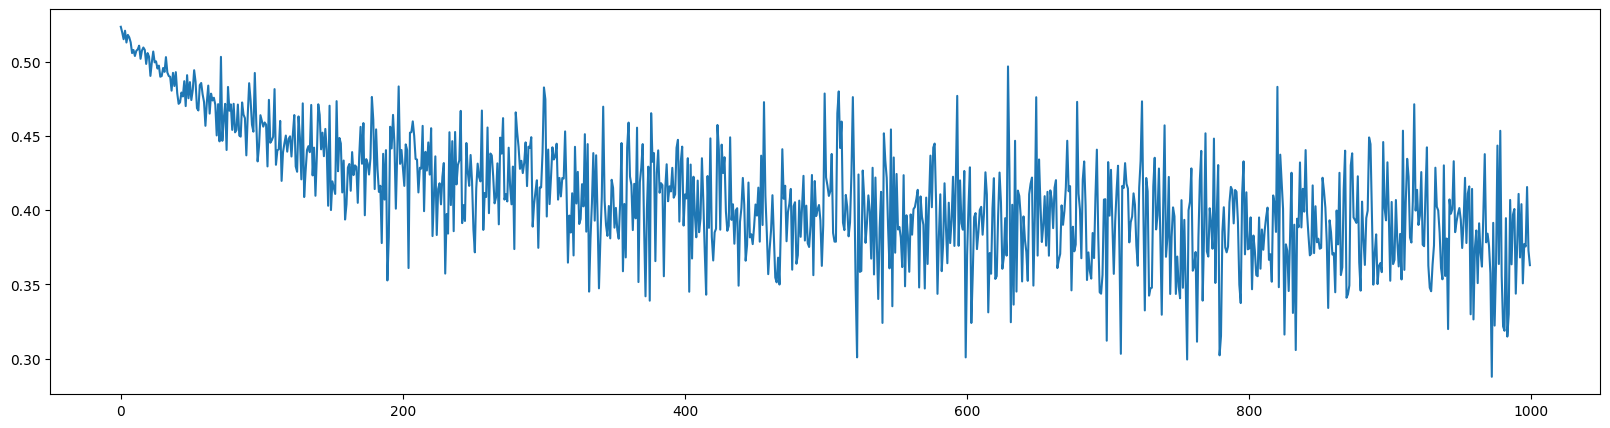

In [4]:
max_steps = 1_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    logits = m(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])

    for layer in m.layers:
        layer.out.retain_grad()
    for p in m.parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in m.parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in m.parameters]
        )

plt.plot(range(len(lossi)), lossi)

## Activation distribution


 3 Tanh () | mean -0.00 | std 0.62 | saturated: 3.44%
 6 Tanh () | mean -0.01 | std 0.64 | saturated: 2.69%
 9 Tanh () | mean -0.00 | std 0.64 | saturated: 2.09%
12 Tanh () | mean -0.00 | std 0.65 | saturated: 2.09%
15 Tanh () | mean -0.00 | std 0.65 | saturated: 1.38%


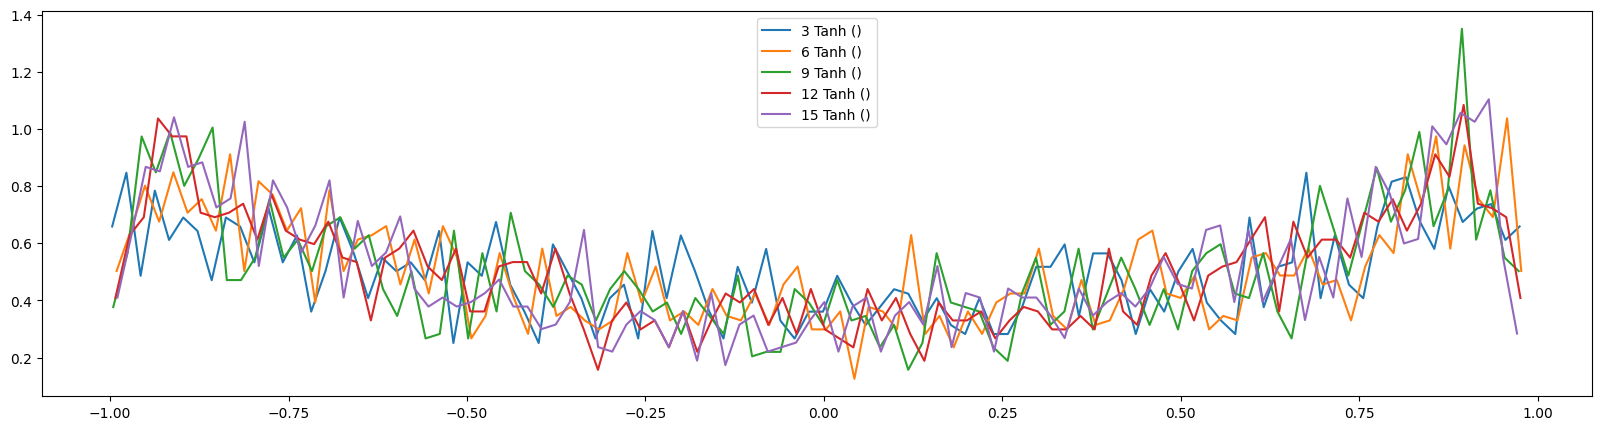

In [5]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Tanh):
        t = l.out.detach()
        print(
            "%2d %s | mean %+.2f | std %.2f | saturated: %.2f%%"
            % (
                i,
                l,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Gradient distribution


 3 Tanh () | mean -0.00 | std +2.90e-03
 6 Tanh () | mean -0.00 | std +2.48e-03
 9 Tanh () | mean +0.00 | std +2.25e-03
12 Tanh () | mean +0.00 | std +2.16e-03
15 Tanh () | mean +0.00 | std +2.16e-03


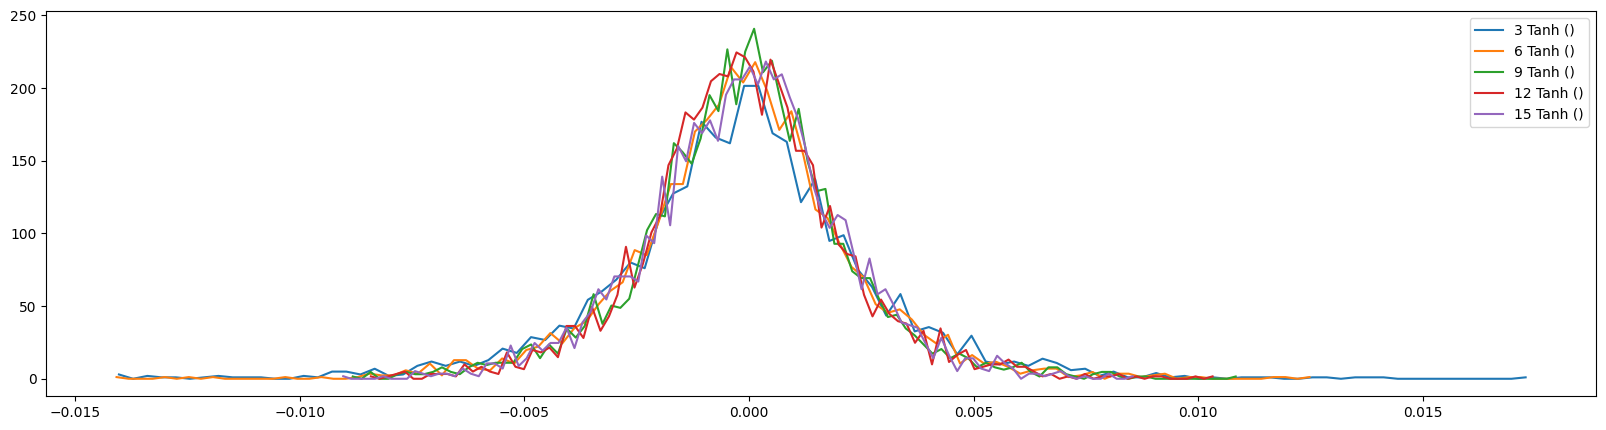

In [6]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Tanh):
        t = l.out.grad.detach()
        print("%2d %s | mean %+.2f | std %+.2e" % (i, l, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Weights grad distribution


 0   Embedding (27, 10) | mean -0.00 | std 8.19e-03 | grad:data 8.25e-03
 1     Linear (30, 100) | mean +0.00 | std 1.12e-02 | grad:data 5.98e-02
 4    Linear (100, 100) | mean +0.00 | std 8.26e-03 | grad:data 8.12e-02
 7    Linear (100, 100) | mean -0.00 | std 6.69e-03 | grad:data 6.56e-02
10    Linear (100, 100) | mean -0.00 | std 6.21e-03 | grad:data 6.11e-02
13    Linear (100, 100) | mean -0.00 | std 5.77e-03 | grad:data 5.71e-02
16     Linear (100, 27) | mean -0.00 | std 1.12e-02 | grad:data 1.05e-01


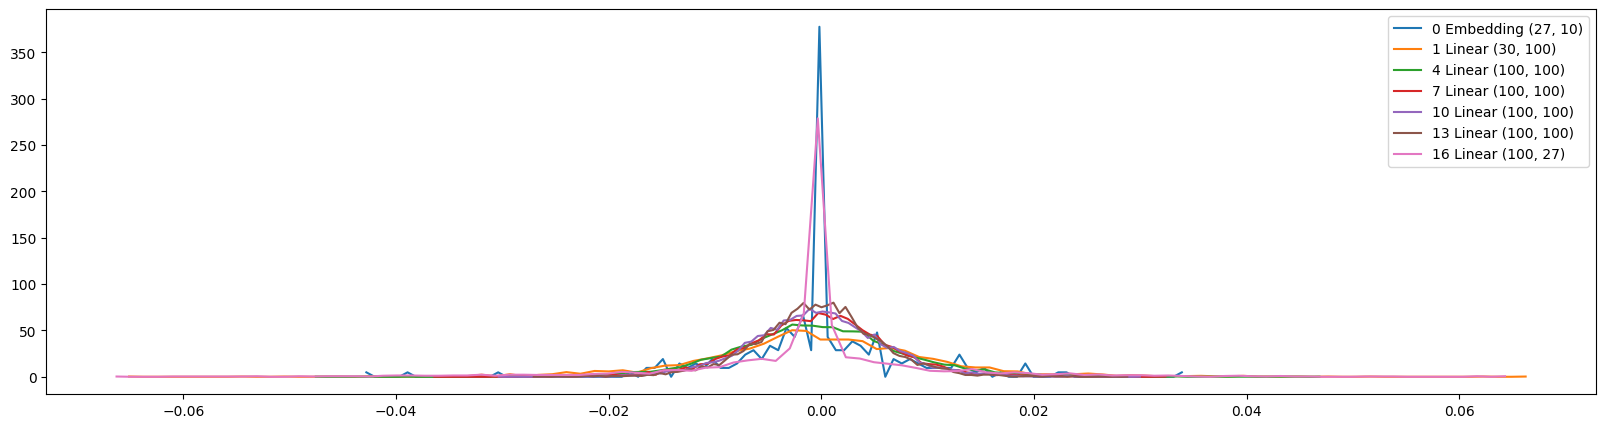

In [7]:
legends = []
# for i, p in enumerate(m.parameters):
#     if p.ndim == 2:
#         t = p.grad.detach()
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Linear) or isinstance(l, nn.Embedding):
        p = l.weight.detach()
        t = l.weight.grad.detach()
        print(
            "%2d %20s | mean %+.2f | std %.2e | grad:data %.2e"
            % (i, l, t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Lr \* grad


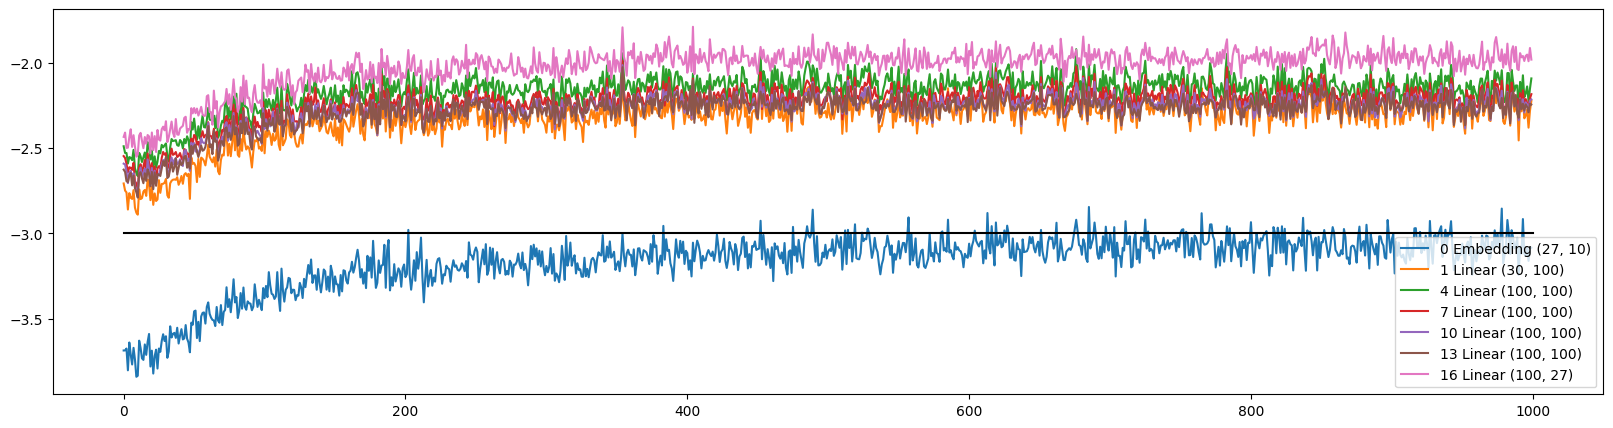

In [8]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Linear) or isinstance(l, nn.Embedding):
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("%d %s" % (i, l))
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)